# Simulation of the Kesten Process from [Hartmann2016](http://journal.frontiersin.org/article/10.3389/fncir.2015.00090/abstract)
(This is for Python 3)

In [1]:
%matplotlib inline
import pylab as pl
import plotting
plotting.pretty_mpl_defaults()
pl.rcParams['figure.figsize'] = (10.0, 8.0)
pl.rcParams['axes.formatter.limits'] = [-3,3]

## Simulation code

In [2]:
# Returns correlation term with bias
def C_range(n, pot_bias):
    tmp = (pl.rand(n)*2)-1.0 
    tmp[tmp>0] *= pot_bias
    return 0.005*tmp

# Dependent_eta = True corresponds to the detailed balance condition in the paper
def sim_kesten(n_syn, n_steps, C_f, pot_bias, f, dependent_eta=True):
    eps = 0.000001
    D = pl.zeros((n_steps,n_syn))
    X_1 = pl.zeros((n_steps,n_syn))
    X_2 = pl.zeros((n_steps,n_syn))
    eta = pl.zeros(n_steps)
    X_1[0] = pl.rand(n_syn)
    X_2[0] = pl.rand(n_syn)
    D[0,:] = X_1[0]-X_2[0]
    for s in range(n_steps-1):
        C = C_f(n_syn, pot_bias) 
        F_1 = (pl.rand(n_syn)>f)+0.
        F_2 = (pl.rand(n_syn)>f)+0.
        T = pl.sum(X_1[s]+X_2[s])
        P_1 = C*F_1
        P_2 = C*F_2
        if dependent_eta:
            eta[s] = -pl.sum(P_1+P_2)/T
        else:
            eta[s] = -pl.randn()*0.001-0.002
        X_1[s+1] = X_1[s] + P_1+eta[s]*X_1[s]
        X_2[s+1] = X_2[s] + P_2+eta[s]*X_2[s]
        D[s+1] = (1+eta[s])*D[s]+C*(F_1-F_2)
        assert((((X_1[s+1]-X_2[s+1])-D[s+1])<eps).all()) # problematic for very large weights
        
    return X_1, X_2, D, eta 

## Simulate and plot single trials for different conditions 

In [3]:
def plot_single(n_syn,n_steps,C_func,pot_bias,p_failure,dependent=True,savestring='kesten_single'):
    X_1, X_2, D, eta = sim_kesten(n_syn,n_steps,C_func,pot_bias,p_failure,dependent_eta=dependent)

    pl.figure()
    pl.plot(X_1[:,0], label='X_1')
    pl.plot(X_2[:,0], label='X_2')
    pl.plot(abs(D[:,0]), label='diff')
    pl.legend(loc='best')
    pl.xlabel('Step')
    pl.ylabel('Weights')
    pl.tight_layout()
    pl.savefig(savestring+'_traces.pdf')
    
    pl.figure()
    pl.plot(X_1[:,0], label='X_1')
    pl.plot(X_2[:,0], label='X_2')
    pl.plot(abs(D[:,0]), label='diff')
    pl.legend(loc='best')
    pl.xlabel('Step')
    pl.semilogy()
    pl.ylabel('Weights')
    pl.tight_layout()
    pl.savefig(savestring+'_logtraces.pdf')

    pl.figure()
    pl.hist(D[-1])
    pl.xlabel('Final distance (var=%.4f)'%pl.std(D[-1])**2)
    pl.ylabel('Frequency')
    pl.savefig(savestring+'_distanceHist.pdf')

    pl.figure()
    pl.hist(abs(D[-1]))
    pl.xlabel('Final absolute distance')
    pl.ylabel('Frequency')
    pl.savefig(savestring+'_absdistanceHist.pdf')
    print('Final mean distance: %.3f'%pl.mean(abs(D[-1])))
    
    pl.figure()
    pl.hist(eta)
    pl.xlabel('$\eta$')
    pl.ylabel('Frequency')
    pl.savefig(savestring+'_etaHist.pdf')

    pl.show()

### Plot with detailed balance

Final mean distance: 0.030


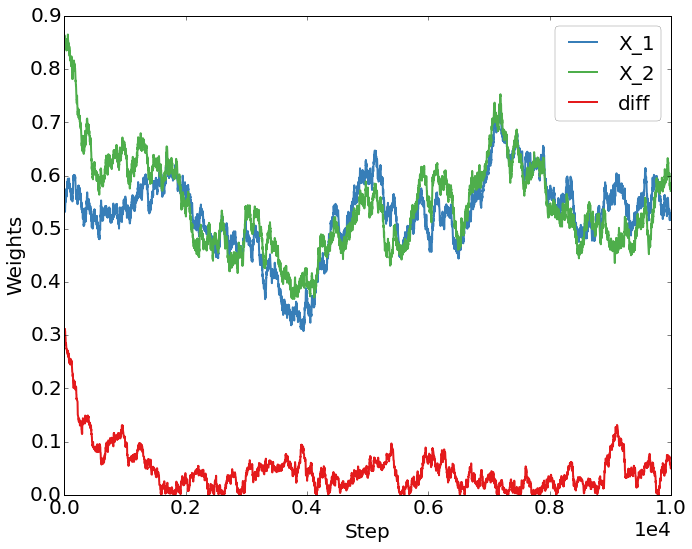

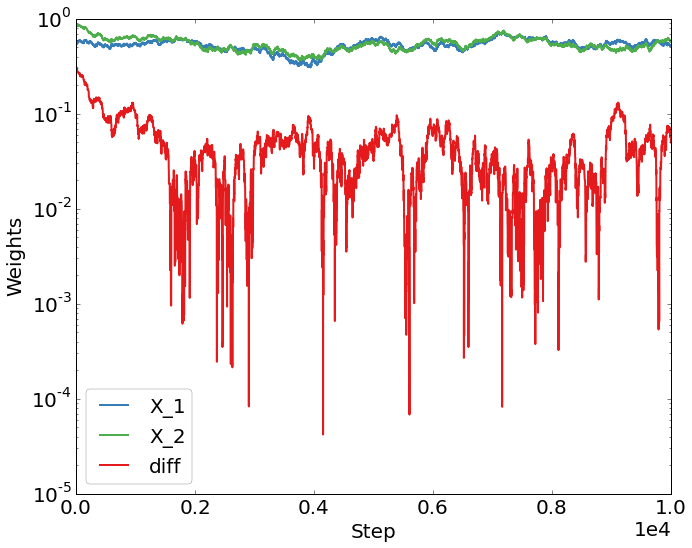

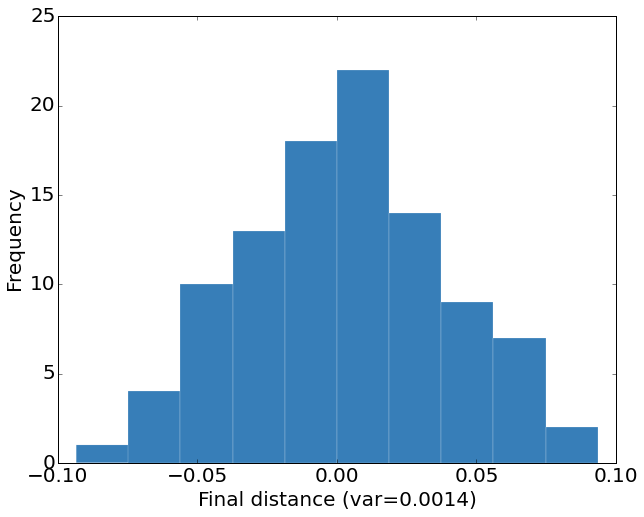

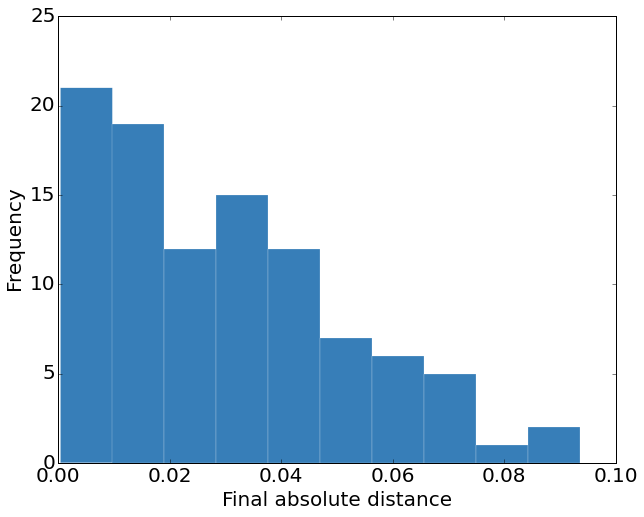

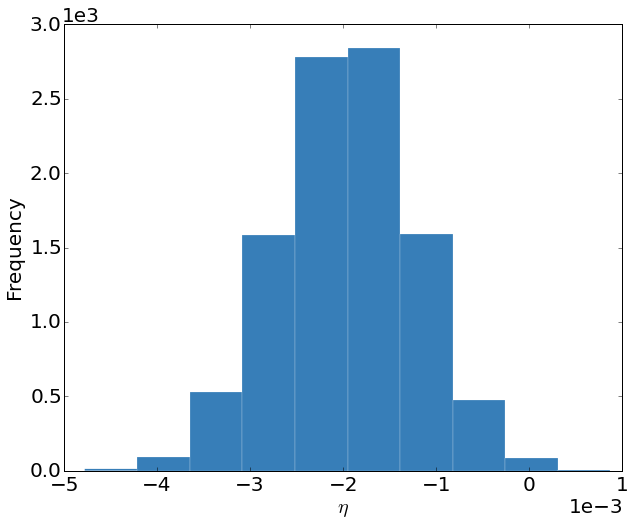

In [4]:
plot_single(n_syn=100,n_steps=10000,C_func=C_range,pot_bias=2.0,p_failure=0.2,dependent=True,savestring='dependent')

### Plot with global balance

Final mean distance: 0.032


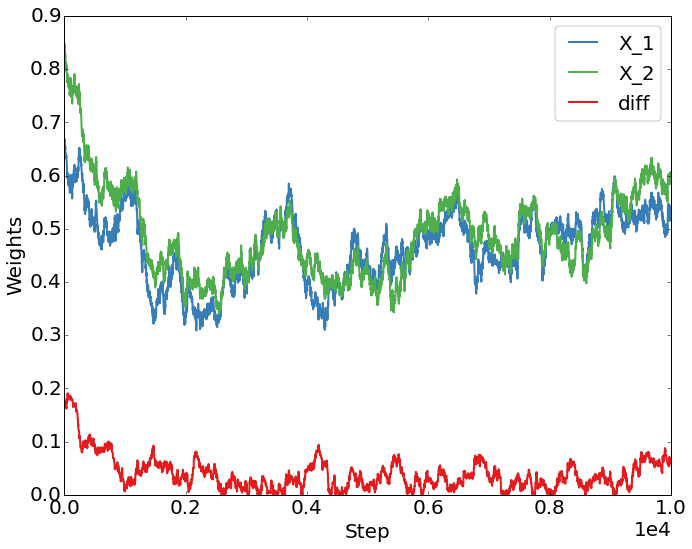

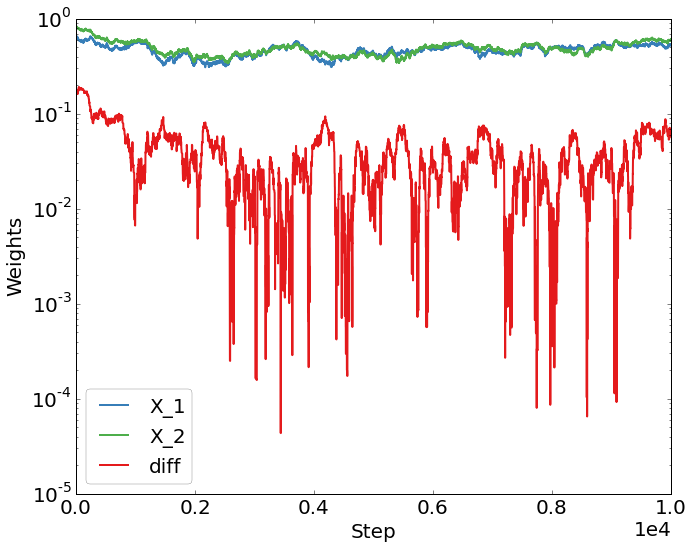

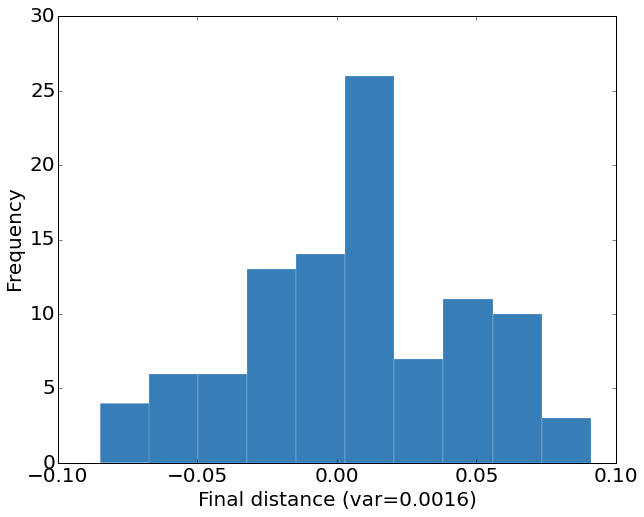

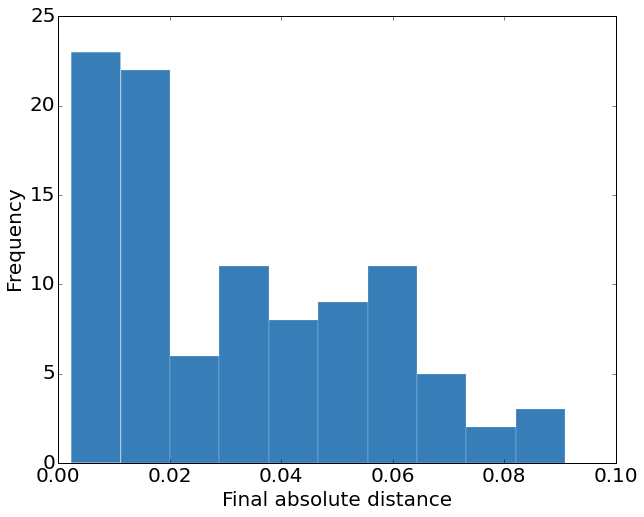

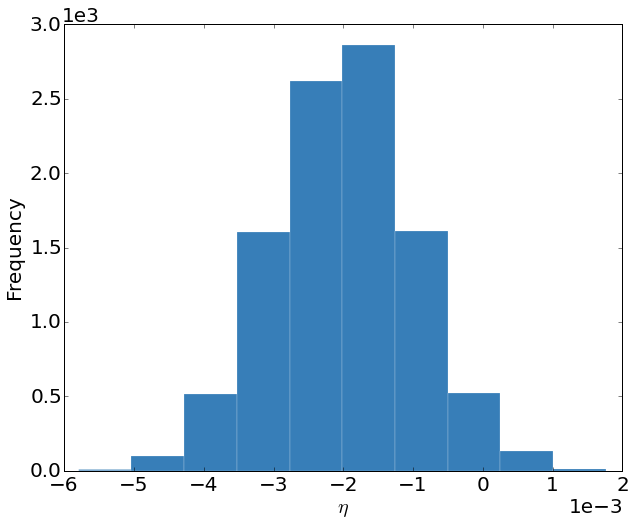

In [5]:
plot_single(n_syn=100,n_steps=10000,C_func=C_range,pot_bias=2.0,p_failure=0.2,dependent=False,savestring='independent')

### Plot with detailed balance and depression bias

Final mean distance: 4692.661


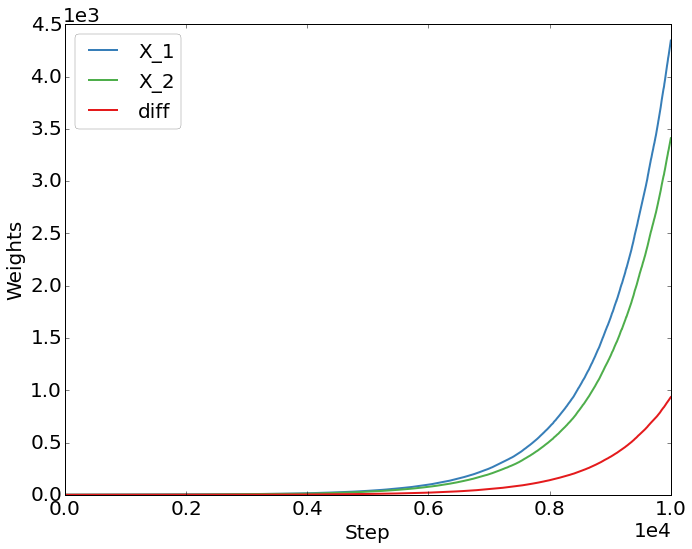

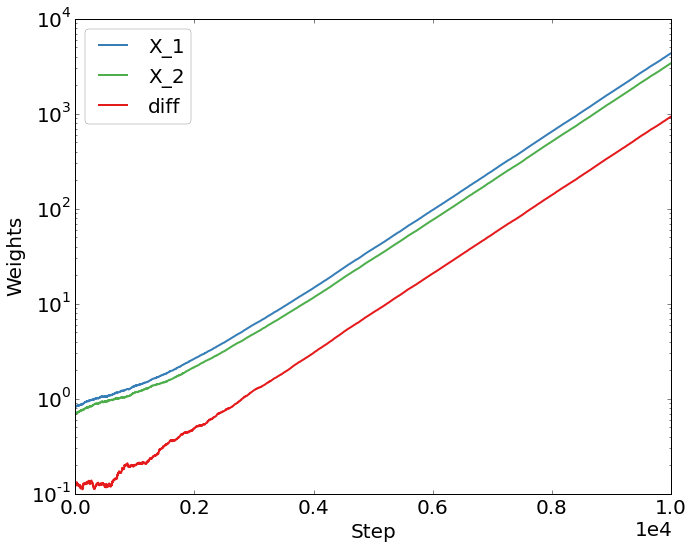

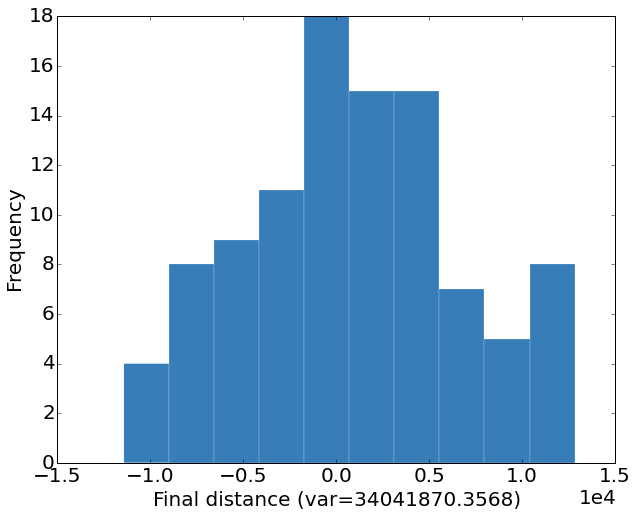

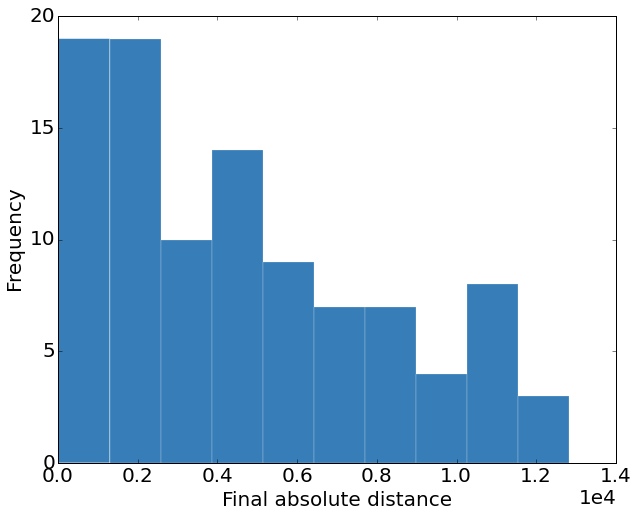

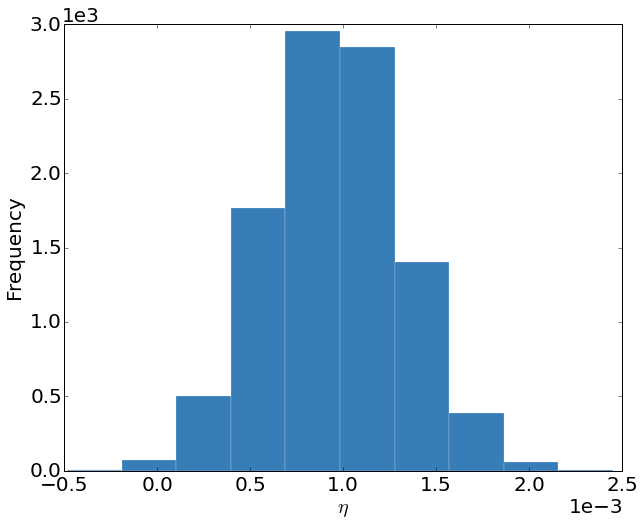

In [6]:
plot_single(n_syn=100,n_steps=10000,C_func=C_range,pot_bias=0.5,p_failure=0.2,dependent=True,savestring='dependent_depbias')

## Simulate and plot trial-averaged data for variance vs. failure

In [7]:
def variance_vs_failure(dependent_eta,savestring='kesten'):
    failures = pl.linspace(0.1,0.9,11)
    steps = [1000,4000,10000]
    n_trials = 10
    variances = pl.zeros((len(failures),n_trials))
    for (s_i,s) in enumerate(steps):
        for (f_i,f) in enumerate(failures):
            for n in range(n_trials):
                _,_,D,_ = sim_kesten(100,s,C_range,2.0,f,dependent_eta=dependent_eta)
                variances[f_i,n] = pl.std(D[-1])**2
        pl.errorbar(failures,pl.mean(variances,1),yerr=pl.std(variances,1)/pl.sqrt(n_trials),label='%d steps'%s)
    pl.xlabel('Probability of synaptic failure')
    pl.legend(loc='best')
    pl.xlim([0,1])
    pl.ylabel('Variance in distance distribution with SEM')
    pl.savefig(savestring+'_var_vs_failure.pdf')
    pl.show()
    

### For the detailed balance

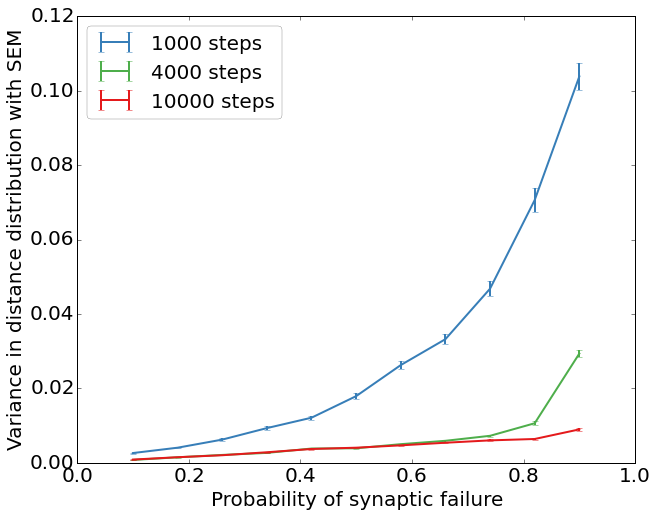

In [8]:
variance_vs_failure(dependent_eta=True,savestring='dependent')

### For the global balance

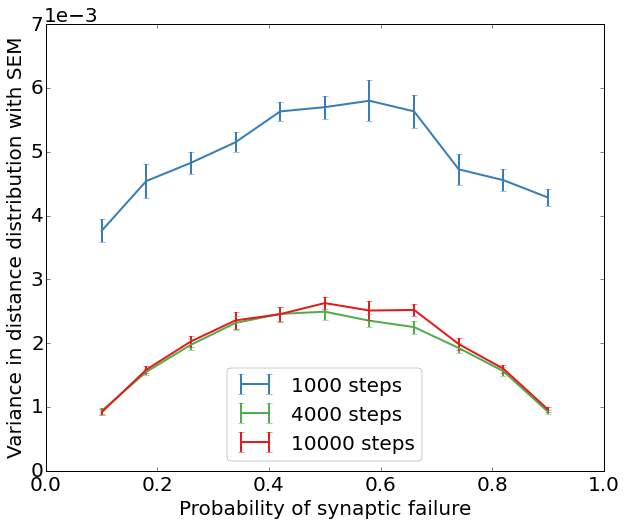

In [9]:
variance_vs_failure(dependent_eta=False,savestring='independent')